<a href="https://colab.research.google.com/github/aneeshbal/SimpylCellCounter/blob/master/recreationFunctions/scc_cnn_time_and_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialize Session

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import pandas as pd
import math

import tensorflow as tf
from tensorflow.keras.models import load_model

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define Functions

In [0]:
def createImg(num_of_objects):
    
    global im, sizes, intensities
    
    im = np.random.randint(165, 200, size = (1460,1920)).astype('uint8')
    obj_num = num_of_objects
    circle_centers = np.random.randint(100, 1300, size = (obj_num, 2))
    intensities = np.random.randint(80, 90, size = (obj_num, 1)).astype('int')
    sizes = np.random.randint(15, 25, size = (obj_num, 1)).astype('int')

    for jj in range(len(circle_centers)):
        cv2.circle(im, (circle_centers[jj][0], circle_centers[jj][1]), sizes[jj], int(intensities[jj]), -1)
        
    ## blur image
    im = cv2.medianBlur(im, 3)
    im = cv2.GaussianBlur(im, (3,3), 9)   
    return im

In [0]:
model = load_model('/content/drive/My Drive/SCC_1x/model_save.h5')

## In Function

In [0]:
set_th_value=150; radius=10; circularity_parameter=0.77

def scc(read, set_th_value=150, radius=10, circularity_parameter=0.77):
  t1 = time.time()
  area_parameter = (3.14*radius**2)/0.95 # do NOT change this formula!
  area_parameter = area_parameter/1.04 # do NOT change this formula!

  img = read
  th_value=set_th_value
  test_thresh, __ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)      
  if test_thresh < np.mean(img):
      img = img
  else:
      img = cv2.bitwise_not(img)    
  new_th, __ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  if area_parameter > 200:
      if th_value/np.mean(img) > 0.63:
          a = 5; b = 3; th_value = th_value; sig = 'first'   
          if th_value > new_th:
              a = 5; b = 3; th_value = new_th
      else:
          a = 3; b = 1                            
  else:    
      if th_value > new_th:
          a = 3; b = 1; th_value = new_th
      else:            
          a = 3; b = 1; sig = 'fifth'
          
  ret, img2 = cv2.threshold(img, th_value, 255, cv2.THRESH_BINARY)
  c_function = cv2.medianBlur(img2, 5)
  c_function = cv2.morphologyEx(c_function, cv2.MORPH_CLOSE, np.ones((a,a)), iterations = b)
  d_function = cv2.erode(c_function, np.ones((1,1)), iterations = 1)
    
  contours, hierarchy = cv2.findContours(d_function, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

  A = []
  df = []
  k = np.empty((1,2))
  for j in range(0, len(contours)):
      M = cv2.moments(contours[j])
      areas = M['m00']
      A.append(areas)

  smallArea = np.where(np.array(A)<area_parameter)
  contours = np.delete(np.array(contours), np.asarray(smallArea).astype('int'))

  for j in range(0, len(contours)):
      M = cv2.moments(contours[j])
      huMoments = cv2.HuMoments(M)
      huMoments = huMoments[0]
      huMoments = -1*math.copysign(1.0, huMoments)*math.log10(abs(huMoments))
      df.append(huMoments)

  df = np.array(df)
  multCirc = np.where(df<circularity_parameter)[0][1:]
  if len(multCirc) == 0:
    counts = len(df)
  else:
    c = [contours[i] for i in multCirc]
    count_array = []
    imgs = []
    for h,cnt in enumerate(c):
        mask = np.ones((img.shape[0]+100, img.shape[1]+100),np.uint8)
        cv2.drawContours(mask,[cnt],0,0,-1)
        (x,y,w,h) = cv2.boundingRect(cnt)
        x1 = x-100; x2 = x+100; y1 = y-100; y2 = y+100
        if x1<0:
            x1=0
        if y1<0:
            y1=0
        if x2<0:
            x2=0
        if y2<0:
            y2=0
        mask_subset = mask[y1:y2, x1:x2]
        mask_subset_resize = cv2.resize(mask_subset, (100, 100))
        im4 = tf.keras.utils.normalize(np.array(mask_subset_resize).reshape(-1, 100, 100, 1))
        count_array += [np.argmax(model.predict(im4))]

    counts = len(df)-len(multCirc)-1+int(sum(np.array(count_array)))
    t2 = time.time()
    times = t2-t1
  #return counts
  return counts

In [0]:
def scc_wo_cnn(read, set_th_value=150, radius=10, circularity_parameter=0.77):
  t1 = time.time()
  area_parameter = (3.14*radius**2)/0.95 # do NOT change this formula!
  area_parameter = area_parameter/1.04 # do NOT change this formula!

  img = read
  th_value=set_th_value
  test_thresh, __ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)      
  if test_thresh < np.mean(img):
      img = img
  else:
      img = cv2.bitwise_not(img)    
  new_th, __ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  if area_parameter > 200:
      if th_value/np.mean(img) > 0.63:
          a = 5; b = 3; th_value = th_value; sig = 'first'   
          if th_value > new_th:
              a = 5; b = 3; th_value = new_th
      else:
          a = 3; b = 1                            
  else:    
      if th_value > new_th:
          a = 3; b = 1; th_value = new_th
      else:            
          a = 3; b = 1; sig = 'fifth'
          
  ret, img2 = cv2.threshold(img, th_value, 255, cv2.THRESH_BINARY)
  c_function = cv2.medianBlur(img2, 5)
  c_function = cv2.morphologyEx(c_function, cv2.MORPH_CLOSE, np.ones((a,a)), iterations = b)
  d_function = cv2.erode(c_function, np.ones((1,1)), iterations = 1)
    
  contours, hierarchy = cv2.findContours(d_function, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

  A = []
  df = []
  k = np.empty((1,2))
  for j in range(0, len(contours)):
      M = cv2.moments(contours[j])
      areas = M['m00']
      A.append(areas)

  smallArea = np.where(np.array(A)<area_parameter)
  contours = np.delete(np.array(contours), np.asarray(smallArea).astype('int'))

  for j in range(0, len(contours)):
      M = cv2.moments(contours[j])
      huMoments = cv2.HuMoments(M)
      huMoments = huMoments[0]
      huMoments = -1*math.copysign(1.0, huMoments)*math.log10(abs(huMoments))
      df.append(huMoments)

  df = np.array(df)
  multCirc = np.where(df<circularity_parameter)[0][1:]
  c = [contours[i] for i in multCirc]
  count_array = []
  
  counts = len(df) 
  t2 = time.time()
  times = t2-t1
  #return counts
  return counts

In [0]:
def scc_mult_circ(read, set_th_value=150, radius=10, circularity_parameter=0.77):
  t1 = time.time()
  area_parameter = (3.14*radius**2)/0.95 # do NOT change this formula!
  area_parameter = area_parameter/1.04 # do NOT change this formula!

  img = read
  th_value=set_th_value
  test_thresh, __ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)      
  if test_thresh < np.mean(img):
      img = img
  else:
      img = cv2.bitwise_not(img)    
  new_th, __ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  if area_parameter > 200:
      if th_value/np.mean(img) > 0.63:
          a = 5; b = 3; th_value = th_value; sig = 'first'   
          if th_value > new_th:
              a = 5; b = 3; th_value = new_th
      else:
          a = 3; b = 1                            
  else:    
      if th_value > new_th:
          a = 3; b = 1; th_value = new_th
      else:            
          a = 3; b = 1; sig = 'fifth'
          
  ret, img2 = cv2.threshold(img, th_value, 255, cv2.THRESH_BINARY)
  c_function = cv2.medianBlur(img2, 5)
  c_function = cv2.morphologyEx(c_function, cv2.MORPH_CLOSE, np.ones((a,a)), iterations = b)
  d_function = cv2.erode(c_function, np.ones((1,1)), iterations = 1)
    
  contours, hierarchy = cv2.findContours(d_function, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

  A = []
  df = []
  k = np.empty((1,2))
  for j in range(0, len(contours)):
      M = cv2.moments(contours[j])
      areas = M['m00']
      A.append(areas)

  smallArea = np.where(np.array(A)<area_parameter)
  contours = np.delete(np.array(contours), np.asarray(smallArea).astype('int'))

  for j in range(0, len(contours)):
      M = cv2.moments(contours[j])
      huMoments = cv2.HuMoments(M)
      huMoments = huMoments[0]
      huMoments = -1*math.copysign(1.0, huMoments)*math.log10(abs(huMoments))
      df.append(huMoments)

  df = np.array(df)
  multCirc = np.where(df<circularity_parameter)[0][1:]
  c = [contours[i] for i in multCirc]
  count_array = []
  
  counts = len(df) 
  t2 = time.time()
  times = t2-t1
  #return counts
  return len(multCirc)

## Accuracy and Time

In [184]:
from tqdm.notebook import tqdm

raw = []
cnn = []
wo_cnn = []
overlaps = []

cnn_time = []
wo_cnn_time = []
overlaps_time = []
for j in tqdm(range(0, 1000)):
  num_objects = np.random.randint(50, 125)
  img = createImg(num_objects)
  raw.append(num_objects)

  cnn1 = time.time()
  cnn.append(scc(img))
  cnn2 = time.time()
  cnn_time.append((cnn2-cnn1))

  wo_cnn1 = time.time()
  wo_cnn.append(scc_wo_cnn(img))
  wo_cnn2 = time.time()
  wo_cnn_time.append((wo_cnn2-wo_cnn1))

  overlaps.append(scc_mult_circ(img))

0.99366893871243
0.9782180198728847


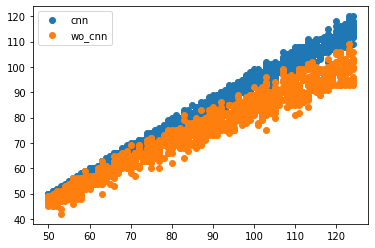

In [185]:
plt.plot(raw, cnn, 'o')
plt.plot(raw, wo_cnn, 'o')
plt.legend(['cnn', 'wo_cnn'])
print(np.corrcoef(raw, cnn)[0,1])
print(np.corrcoef(raw, wo_cnn)[0,1])

In [186]:
cnn_sub = np.abs(np.array(raw)-np.array(cnn))
wo_cnn_sub = np.abs(np.array(raw)-np.array(wo_cnn))

cnn_mean = np.mean(cnn_sub)
wo_cnn_mean = np.mean(wo_cnn_sub)

cnn_sem = np.std(cnn_sub)/np.sqrt(len(cnn_sub))
wo_cnn_sem = np.std(wo_cnn_sub)/np.sqrt(len(wo_cnn_sub))

print(cnn_mean, cnn_sem)
print(wo_cnn_mean, wo_cnn_sem)

4.718 0.10084877788054747
12.369 0.21127905480667034


cnn corr is 0.6341499364041328
wo_cnn corr is 0.9296328699613695


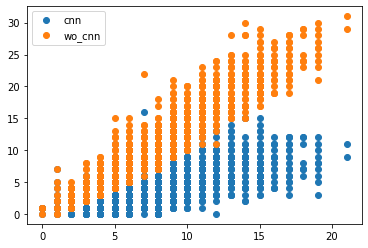

In [187]:
plt.plot(overlaps, cnn_sub, 'o')
plt.plot(overlaps, wo_cnn_sub, 'o')
plt.legend(['cnn', 'wo_cnn'])
print('cnn corr is', np.corrcoef(overlaps, cnn_sub)[0,1])
print('wo_cnn corr is', np.corrcoef(overlaps, wo_cnn_sub)[0,1])

0.9748498487945766
0.0905374212607924


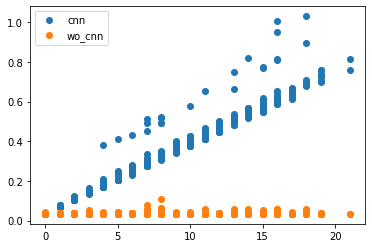

In [190]:
plt.plot(overlaps, cnn_time, 'o')
plt.plot(overlaps, wo_cnn_time, 'o')
plt.legend(['cnn', 'wo_cnn'])
print(np.corrcoef(overlaps, cnn_time)[0,1])
print(np.corrcoef(overlaps, wo_cnn_time)[0,1])

## Save

In [0]:
#np.savetxt('/content/drive/My Drive/SCC_1x/raw.csv', raw, delimiter=',')
#np.savetxt('/content/drive/My Drive/SCC_1x/cnn.csv', cnn, delimiter=',')
#np.savetxt('/content/drive/My Drive/SCC_1x/wo_cnn.csv', wo_cnn, delimiter=',')
#np.savetxt('/content/drive/My Drive/SCC_1x/overlaps.csv', overlaps, delimiter=',')

In [191]:
save_array = np.vstack((raw, cnn, wo_cnn, overlaps, cnn_time, wo_cnn_time)).T
print(save_array.shape)

(1000, 6)


In [0]:
#np.savetxt('/content/drive/My Drive/SCC_1x/save_array.csv', save_array, delimiter=',')